# **LoanGuard: Model Training** 🚀

## **Objective**
This notebook focuses on building and evaluating machine learning models for **loan default prediction** using Lending Club data. The goal is to create a robust model that can accurately classify borrowers into **"Fully Paid"** and **"Charged Off"** categories, helping lenders make informed decisions.

## **Models to be Implemented**
- ✔️ **Baseline Models**: Logistic Regression, Naive Bayes, K-Nearest Neighbors (KNN)
- ✔️ **Tree-Based Models**: Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost
- ✔️ **Artificial Neural Network (ANN)**: Deep learning-based approach for capturing complex patterns
- ✔️ **Stacking Ensemble**: Combining multiple models for better predictive power

## **Expected Outcome**
By the end of this notebook, we aim to have a **high-performing loan default prediction model** that balances **accuracy, precision, and recall**, ensuring minimal false negatives (misclassified defaulters).

---

### 1. **Loading Libs**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import time
import os
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# NN
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

### 2. **Load and Preprocess Data**

In [2]:
# Load train and test data
df_train = pd.read_csv('../data/processed/train.csv')
df_test = pd.read_csv('../data/processed/test.csv')

In [3]:
def encode_target(df):
    """Encode loan_status: Fully Paid -> 0, Charged Off -> 1"""
    df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
    return df

In [4]:
df_train = encode_target(df_train)
df_test = encode_target(df_test)

In [5]:
# Define features and target
X_train = df_train.drop(columns=['loan_status'])
y_train = df_train['loan_status']
X_test = df_test.drop(columns=['loan_status'])
y_test = df_test['loan_status']

In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3. Define Model Evaluation Function

#### 3.1 Traditional Model Evaluation Function

In [7]:
def evaluate_model(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

#### 3.2 Neural Network Evaluation Function and Learning Plots

In [8]:
def evaluate_neural_network(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [9]:
def plot_learning_evolution(r):
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(r.history['loss'], label='Training Loss', color='red', linestyle='--', marker='o')
    ax1.plot(r.history['val_loss'], label='Validation Loss', color='red', linestyle='-', marker='s')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()
    ax2.plot(r.history['AUC'], label='Training AUC', color='blue', linestyle='--', marker='o')
    ax2.plot(r.history['val_AUC'], label='Validation AUC', color='blue', linestyle='-', marker='s')
    ax2.set_ylabel("AUC Score", color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc="upper right")

    plt.title("Model Training Performance (Loss & AUC)")
    plt.show()

In [10]:
def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [11]:
# Train and evaluate Neural Network
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3

### 4. Model training

In [12]:
# Dictionary to store scores
scores_dict = {}
model_results = {}

#### 4.1 Traditional Models

In [13]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='saga'),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": LGBMClassifier(device="gpu"),
    "CatBoost": CatBoostClassifier(task_type="GPU", verbose=0)
}

In [14]:
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    
    # Train predictions
    y_train_pred = model.predict(X_train)
    evaluate_model(y_train, y_train_pred.round(), train=True)

    # Test predictions
    y_test_pred = model.predict(X_test)
    evaluate_model(y_test, y_test_pred.round(), train=False)
    
    model_results[name] = accuracy_score(y_test, y_pred)
    
    if hasattr(model, 'predict_proba'):
        train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]) * 100
        test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) * 100
    else:
        train_roc_auc = roc_auc_score(y_train, model.predict(X_train)) * 100
        test_roc_auc = roc_auc_score(y_test, y_pred) * 100
    
    scores_dict[name] = {
        'Train': train_roc_auc,
        'Test': test_roc_auc
    }
    print(scores_dict[name])

Training Logistic Regression...
Time taken: 259.23 seconds
Train Result:
Accuracy Score: 88.92%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.883365      0.943596  0.889179       0.913480       0.895198
recall          0.993224      0.463644  0.889179       0.728434       0.889179
f1-score        0.935079      0.621774  0.889179       0.778426       0.873525
support    212505.000000  51958.000000  0.889179  264463.000000  264463.000000
_______________________________________________
Confusion Matrix: 
 [[211065   1440]
 [ 27868  24090]]

Test Result:
Accuracy Score: 88.92%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.883839      0.939727  0.889214       0.911783       0.894758
recall          0.992796      0.462598  0.889214       0.727697      

#### 4.1 Artificial Neural Network (ANN)

In [15]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [16]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3

ann = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)

r = ann.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
8265/8265 [==============================] - 23s 3ms/step - loss: 0.3079 - AUC: 0.8603 - val_loss: 0.2739 - val_AUC: 0.8978
Epoch 2/20
8265/8265 [==============================] - 21s 3ms/step - loss: 0.2910 - AUC: 0.8773 - val_loss: 0.2734 - val_AUC: 0.9035
Epoch 3/20
8265/8265 [==============================] - 20s 2ms/step - loss: 0.2859 - AUC: 0.8823 - val_loss: 0.2805 - val_AUC: 0.9051
Epoch 4/20
8265/8265 [==============================] - 20s 2ms/step - loss: 0.2822 - AUC: 0.8854 - val_loss: 0.2617 - val_AUC: 0.9057
Epoch 5/20
8265/8265 [==============================] - 21s 3ms/step - loss: 0.2807 - AUC: 0.8873 - val_loss: 0.2672 - val_AUC: 0.9057
Epoch 6/20
8265/8265 [==============================] - 21s 3ms/step - loss: 0.2798 - AUC: 0.8883 - val_loss: 0.3638 - val_AUC: 0.9061
Epoch 7/20
8265/8265 [==============================] - 21s 3ms/step - loss: 0.2787 - AUC: 0.8890 - val_loss: 0.4961 - val_AUC: 0.9050
Epoch 8/20
8265/8265 [==============================] -

In [17]:
y_train_pred = ann.predict(X_train)
evaluate_neural_network(y_train, y_train_pred.round(), train=True)

y_test_pred = ann.predict(X_test)
evaluate_neural_network(y_test, y_test_pred.round(), train=False)

scores_dict["ANN"] = {
    "Train": roc_auc_score(y_train, ann.predict(X_train)) * 100,
    "Test": roc_auc_score(y_test, ann.predict(X_test)) * 100,
}
print(scores_dict["ANN"])
model_results["ANN"] = accuracy_score(y_test, y_pred)

8265/8265 [==============================] - 6s 668us/step
Train Result:
Accuracy Score: 88.90%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.885675      0.918351  0.889013       0.902013       0.892094
recall          0.989619      0.477540  0.889013       0.733579       0.889013
f1-score        0.934766      0.628343  0.889013       0.781554       0.874564
support    212505.000000  51958.000000  0.889013  264463.000000  264463.000000
_______________________________________________
Confusion Matrix: 
 [[210299   2206]
 [ 27146  24812]]

4076/4076 [==============================] - 3s 725us/step
Test Result:
Accuracy Score: 88.91%
_______________________________________________
CLASSIFICATION REPORT:
                     0.0           1.0  accuracy      macro avg   weighted avg
precision       0.886473      0.912562  0.889145       0.899518       0.891570
recall    

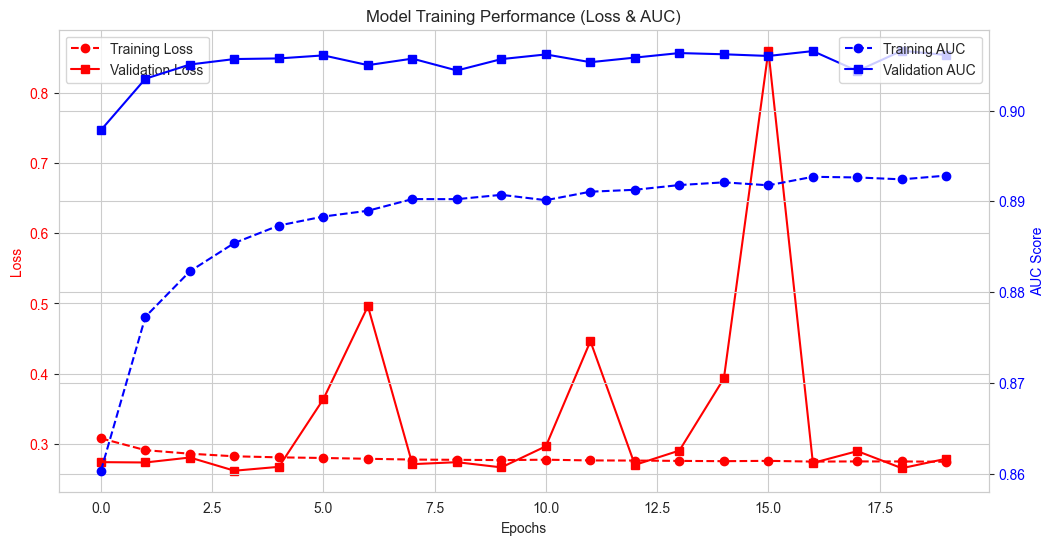

In [18]:
# Plot training progress of Artifical Neural Network
plot_learning_evolution(r)

In [19]:
scores_df = pd.DataFrame(scores_dict)
scores_df.hvplot.barh(
    width=700, height=500, 
    title="Train vs Test ROC Scores of ML Models", xlabel="ROC AUC Score (%)", 
    alpha=0.6, legend='top'
)

:Bars   [index,Variable]   (value)

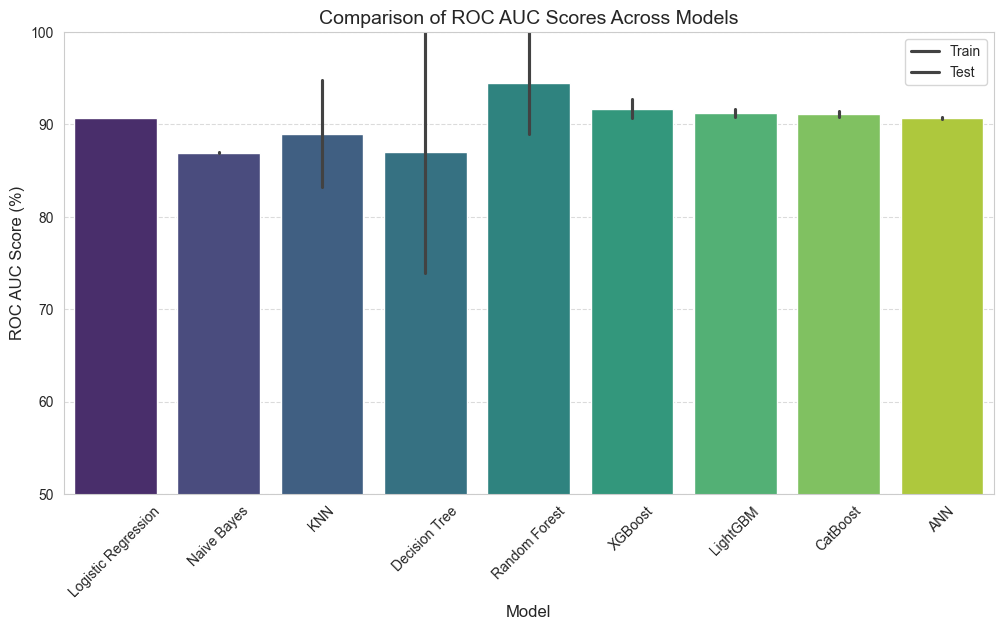

In [20]:
# Plot the ROC AUC scores
plt.figure(figsize=(12, 6))
sns.barplot(data=scores_df, palette="viridis")
plt.title("Comparison of ROC AUC Scores Across Models", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("ROC AUC Score (%)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(50, 100)  # Set a reasonable range for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(["Train", "Test"])
plt.show()

### 5. Model Comparison & Selection

In [21]:
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df)

                 Model  Accuracy
7             CatBoost  0.889843
8                  ANN  0.889843
6             LightGBM  0.889728
0  Logistic Regression  0.889214
4        Random Forest  0.889168
5              XGBoost  0.888402
2                  KNN  0.872193
1          Naive Bayes  0.867654
3        Decision Tree  0.828658


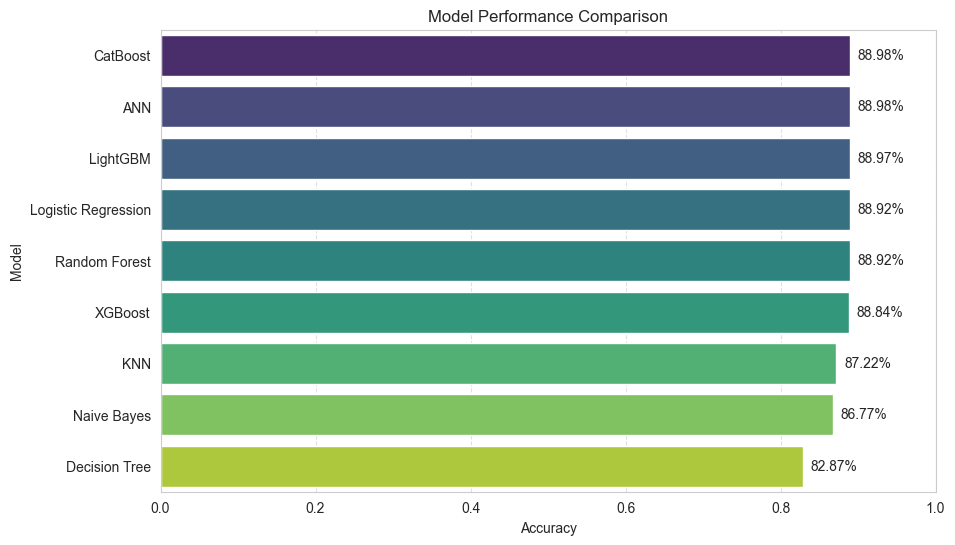

In [22]:
# 📊 Visualization of Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df["Accuracy"], y=results_df["Model"], palette="viridis", hue=results_df["Model"], legend=False)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Performance Comparison")
plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Display the accuracy values on the bars
for index, value in enumerate(results_df["Accuracy"]):
    plt.text(value + 0.01, index, f"{value:.2%}", va="center")

plt.show()

### 6. Saving the top 2 performers

In [25]:
top_2_models = results_df.head(2)

os.makedirs("../artifacts", exist_ok=True)
for index, row in top_2_models.iterrows():
    if model_name == "ANN": continue
    model_name = row['Model']
    model = models[model_name]
    filename = f"../artifacts/{model_name.replace(' ', '_')}.pkl"
    joblib.dump(model, filename)
    print(f"✅ Saved {model_name} to {filename}")

In [26]:
# Save ANN model in HDF5 format
ann_filename = "../artifacts/Artificial_Neural_Network.h5"
ann.save(ann_filename)
print(f"✅ Saved Artificial Neural Network model to {ann_filename}")

✅ Saved Artificial Neural Network model to ../artifacts/Artificial_Neural_Network.h5
